In [67]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ummc_ppg_loader import PPGDataset, DFS

sys.path.append(os.path.join(os.path.curdir, 'trained_model'))

from trained_model.src.models.utils import load_model
import trained_model.utils.consts as consts
from trained_model.src.train_and_eval import eval

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, recall_score
from sklearn.preprocessing import normalize

from pprint import pp, pprint

from tabulate import tabulate

In [2]:
# Load 1D-CNN
af_1d_cnn = load_model(consts.path_models['1D-CNN'], algo='1D-CNN')['classifier']
af_1d_cnn

In [4]:
dataset = PPGDataset('data', freq=DFS)
dataset.process_signals()
all_windows = [x for x in dataset]

In [5]:
all_windows[0]

(array([ 860.,  820.,  820.,  780.,  820.,  840.,  740., 1080.,  600.,
        1040.,  580.,  840.,  780.,  820.,  800.,  840.,  800.,  800.,
         820.,  820.,  860.,  720.,  980.,  660.,  840.,  900.,  780.,
         520.,  360.,  680.,  840.,  820.,  820.,  820., 1320.,  340.,
         780.,  880.,  680.,  640.,  800.,  560.,  240., 1120.,  720.,
         640.,  660.,  800.,  520.,  580.,  700.,  680.,  600., 1100.,
         140.,  940.,  780.,  440.,  780.,  440.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 0,
 '4033')

In [99]:
def eval_af_predictions(y_true, y_predict):
    print('Precision:', metrics.precision_score(y_true, y_predict))
    print('Recall:', metrics.recall_score(y_true, y_predict))
    print('Accuracy:', metrics.accuracy_score(y_true, y_predict))
    print('Confusion Matrix:')
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_predict).ravel()
    print(tabulate([
        [f'TP {tp}', f'FN {fn}'],
        [f'FP {fp}', f'TN {tn}']

    ]))
    fpr, tpr, _ = metrics.roc_curve(y_true, y_predict)
    plt.figure()
    plt.plot()
    

In [26]:
y = [bool(max(w[1])) for w in all_windows]
X = [w[0] for w in all_windows]
X = np.vstack(X)

print(X.shape)

(2221, 60)


In [97]:
x = X.reshape(X.shape[0], X.shape[1], 1)
y_score = af_1d_cnn.model.predict(x)


70/70 [==============================] - 1s 13ms/step


In [100]:
eval_af_predictions(y, y_score)

In [28]:
accuracy_score(y, y_predict)

0.6334984241332733

In [29]:
f1_score(y, y_predict)

0.10549450549450551

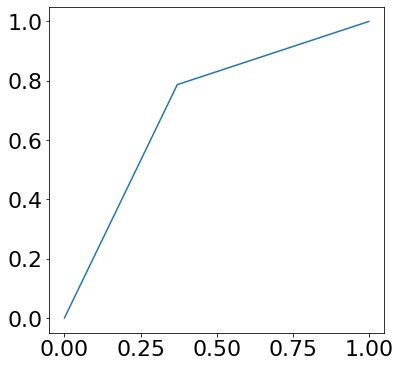

In [33]:
tpr, fpr ,L = roc_curve(y, y_predict)

plt.figure(figsize=(6,6))
plt.plot(tpr, fpr)
plt.show()

In [58]:
Z = normalize(X, axis=1)
y_predict = af_1d_cnn.predict(X)
accuracy_score(y,y_predict), f1_score(y, y_predict), recall_score(y, y_predict)

3/3 [==============================] - 1s 224ms/step


(0.6334984241332733, 0.10549450549450551, 0.7868852459016393)

In [ ]:
algo='ArNet2'
model_path = 'trained_model/saved_models/ArNet2/ArNet2.pkl'
feature_extractor_path = consts.path_models['ResNet']

model = load_model(model_path, algo, feature_extractor_path)
classifier = model['classifier']

In [ ]:
afdb_input = pickle.load(open('trained_model/inputs/AFDB_input.pickle', 'rb'))
afdb_input

In [ ]:
# y_true = []
# y_predict = []
# for x,y in dataset:
#     x = x.reshape(1,-1)
#     x = np.concatenate([x, np.zeros((1,60))],axis=1)[:,:63]
#     y_predict.append(classifier.predict_proba(x))

In [ ]:
x,y = dataset[0]
print(x.shape)
window_id = 0

x = np.concatenate([x, [0], [0], np.array(['PID1'])], dtype=object)
x

In [ ]:
classifier.predict_proba(x)